In [1]:
import pandas as pd 
import os, glob
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [106]:
df = pd.concat((pd.read_csv(f, engine="python") for f in glob.glob(r"gemini_BTCUSD_20[12][90]*.csv")), ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d %H:%M:%S")
df = df.drop(["Symbol", "Unix Timestamp"], axis=1)
# df = df.resample("30T", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum, "High": np.max, "Low": np.min})
df.dropna()
# df = df.drop("Date", axis=1)
df["diff"] = (df["Close"] - df["Open"])/df["Close"]
df["inc"] = df["diff"].apply(lambda x: 1 if x > 0 else 0)
df["dec"] = df["diff"].apply(lambda x: 0 if x > 0 else 1)
df["change"] = df["inc"] - df["inc"].shift(-1)
df["volatility"] = (increasing["High"] - increasing["Low"])
df["volatility"] = df["volatility"]/df["volatility"].mean()
df["next_inc"] = df["inc"].shift(-1)

df.head()

,Date,Open,High,Low,Close,Volume,diff,inc,dec,change,volatility,next_inc
0,2021-02-20 00:02:00,56178.00,56200.00,56141.15,56200.00,4.708759,0.000391,1,0,0.0,4.114225,1.0
1,2021-02-20 00:01:00,56034.59,56178.00,56034.59,56178.00,2.000919,0.002553,1,0,0.0,10.025846,1.0
2,2021-02-20 00:00:00,55984.59,56102.16,55984.59,56034.59,10.365388,0.000892,1,0,0.0,8.219362,1.0
3,2021-02-19 23:59:00,55955.70,55984.59,55896.01,55984.59,0.416505,0.000516,1,0,1.0,NaN,0.0
4,2021-02-19 23:58:00,55999.97,55999.97,55899.67,55955.70,0.496324,-0.000791,0,1,-1.0,7.012010,1.0


                Open           High            Low          Close  \
count  491321.000000  491321.000000  491321.000000  491321.000000   
mean    11644.178411   11651.260214   11638.066927   11645.033073   
std      8735.682995    8744.417061    8726.305455    8735.881650   
min      3341.600000    3351.180000    3341.320000    3348.410000   
25%      7423.960000    7429.400000    7421.120000    7425.060000   
50%      9314.520000    9318.650000    9312.850000    9315.000000   
75%     11346.640000   11349.780000   11343.850000   11347.470000   
max     56320.300000   56407.860000   56231.000000   56276.030000   

              Volume          diff            inc            dec  \
count  491321.000000  4.913210e+05  491321.000000  491321.000000   
mean        1.482764  8.787693e-05       0.500001       0.499999   
std         6.389298  1.152481e-03       0.500001       0.500001   
min         0.000000 -7.560898e-02       0.000000       0.000000   
25%         0.010730 -1.945253e-04    

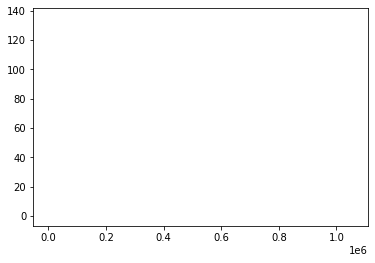

In [120]:
rolling_diff_avg = df.rolling(7*60*24, on="Date").mean()

constant = df[df["next_inc"] == df["inc"]]
changing = df[df["next_inc"] != df["inc"]]
print(changing.describe())
# inc_vol = constant["volatility"]
dec_vol = changing["volatility"]
# plt.plot(inc_vol, "blue")
plt.plot(dec_vol, "orange")
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.6297e+05, 1.9420e+03, 2.3100e+02, 4.9000e+01, 2.0000e+01,
        8.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([6.35672133e-04, 8.80793665e+00, 1.76152376e+01, 2.64225386e+01,
        3.52298396e+01, 4.40371406e+01, 5.28444415e+01, 6.16517425e+01,
        7.04590435e+01, 7.92663445e+01, 8.80736454e+01]),
 <BarContainer object of 10 artists>)

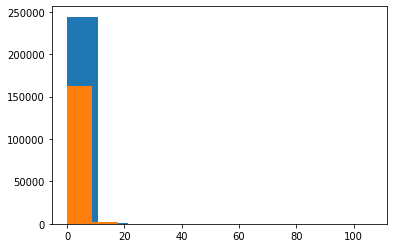

In [101]:
plt.hist(df[df["change"] != 0]["volatility"])
plt.hist(df[df["change"] == 0]["volatility"])

In [66]:
def split_dataset(dataset, split=2/3):
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    print(train_size, test_size)
    train = dataset[:train_size]
    test = dataset[train_size:]
    return train, test

In [74]:
# dropped = df.drop(["High", "Low", "Volume", "Open", "Close"], axis=1)
train, test = split_dataset(df);
print(train.head())

y = train["inc"].apply(lambda x: [0, 1] if x == 1 else [1, 0])
len(train)
train_generator = TimeseriesGenerator(train.to_numpy(), train["inc"].apply(lambda x: [0, 1] if x == 1 else [1, 0]), length=24, batch_size=512)
test_generator = TimeseriesGenerator(test.to_numpy(), test["inc"].apply(lambda x: [0, 1] if x == 1 else [1, 0]), length=24, batch_size=512)
print(len(train_generator))
print(train_generator[1])


24992 12497
                        Open    Close      Volume     High      Low      diff  \
Date                                                                            
2019-01-01 00:00:00  3692.35  3683.12   35.991068  3695.00  3680.77 -0.002506   
2019-01-01 00:30:00  3683.12  3696.16   22.525871  3700.00  3683.12  0.003528   
2019-01-01 01:00:00  3696.16  3692.77   81.746614  3696.35  3681.95 -0.000918   
2019-01-01 01:30:00  3692.77  3679.18   67.454267  3692.85  3666.91 -0.003694   
2019-01-01 02:00:00  3679.18  3671.43  594.284951  3680.00  3577.18 -0.002111   

                     inc  dec  
Date                           
2019-01-01 00:00:00    0    1  
2019-01-01 00:30:00    1    0  
2019-01-01 01:00:00    0    1  
2019-01-01 01:30:00    0    1  
2019-01-01 02:00:00    0    1  
49
(array([[[ 3.63655000e+03,  3.64574000e+03,  6.55243750e+01, ...,
          2.52075025e-03,  1.00000000e+00,  0.00000000e+00],
        [ 3.64574000e+03,  3.64437000e+03,  6.31951991e+01, ...,
 

In [75]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError


model = models.Sequential()
# model.add(Input(shape=train_generator[0][0].shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
model.add(Dropout(.1))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile("adam", CategoricalCrossentropy())
model.fit(train_generator, epochs=1)
model.summary()


49/49 [==============================] - 1s 13ms/step - loss: 0.6922
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, None, 128)         70144     
_________________________________________________________________
lstm_45 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_46 (LSTM)               (None, None, 32)          12416     
_________________________________________________________________
lstm_47 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                1088      
__________________________________________________

In [76]:
predictions = model.predict(test_generator)

array([0.33819714, 0.6618028 ], dtype=float32)

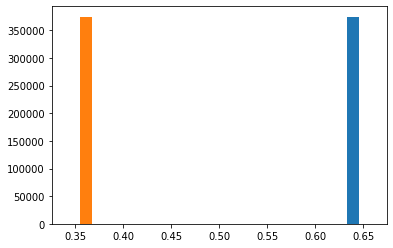

In [70]:
plt.hist(predictions)
np.unique(predictions)

ValueError: min_periods must be an integer